# Merging Data 1

In [1]:
import os
import pandas as pd

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

## Join Types

After we load up the basic packages lets go ahead a merge some data. First we will start with the same data set we worked with last time. 

In [5]:
os.chdir('data (1)')

In [6]:
food_data = pd.read_csv('food_all.csv', encoding='latin-1')

We don't need all the columns we did last time, so lets just keep a couple for today.

In [7]:
keep_cols = ['ccode', 'country', 'leader', 'year', 'elected', 'age', 'male',
       'militarycareer', 'government',
       'prev_conflict', 'pt_suc', 'pt_attempt', 'precip', 'couprisk',
       'democracy', 'autocracy', 'day', 'date', 'GEO',
       '_ISO3N_', 'M49 Code_x', 'percap cals']

In [8]:
food_data = food_data[keep_cols]

In [9]:
food_data.head()

,ccode,country,leader,year,elected,age,male,militarycareer,government,prev_conflict,pt_suc,pt_attempt,precip,couprisk,democracy,autocracy,day,date,GEO,_ISO3N_,M49 Code_x,percap cals
0,2,USA,Truman,1950,1,66,1,0,Presidential Democracy,0,0,0,-0.022443,NaN,1,0,1,12/1/1950,Northern America,840,840.0,NaN
1,2,USA,Truman,1951,1,67,1,0,Presidential Democracy,0,0,0,0.360381,NaN,1,0,1,12/1/1951,Northern America,840,840.0,NaN
2,2,USA,Truman,1952,1,68,1,0,Presidential Democracy,0,0,0,-0.637583,NaN,1,0,1,12/1/1952,Northern America,840,840.0,NaN
3,2,USA,Eisenhower,1953,1,63,1,1,Presidential Democracy,0,0,0,-0.437170,NaN,1,0,1,12/1/1953,Northern America,840,840.0,NaN
4,2,USA,Eisenhower,1954,1,64,1,1,Presidential Democracy,0,0,0,-0.427828,NaN,1,0,1,12/1/1954,Northern America,840,840.0,NaN


Alright so we have a few columns that can serve as grouping variables in this data set. Let's try to get some additional data in our "data" folder. 

First go to this website: http://www.politicalterrorscale.org/Data/Download.html

Click on the download option for the csv file. Once this is done go ahead and move the file into the data folder.  You will have to copy and paste, or just drage the file from Downloads into the labs>data folder. Next we will just load in that data.

In [10]:
pts_data = pd.read_csv('PTS-2019.csv', encoding='latin-1')

Lets check out what this data looks like now. 

In [18]:
pts_data.tail()

,Country,Country_OLD,Year,COW_Code_A,COW_Code_N,WordBank_Code_A,UN_Code_N,Region,PTS_A,PTS_H,PTS_S,NA_Status_A,NA_Status_H,NA_Status_S
9064,Zimbabwe,Zimbabwe,2014,ZIM,552.0,ZWE,716.0,ssa,3.0,3.0,3.0,0,0,0
9065,Zimbabwe,Zimbabwe,2015,ZIM,552.0,ZWE,716.0,ssa,3.0,3.0,4.0,0,0,0
9066,Zimbabwe,Zimbabwe,2016,ZIM,552.0,ZWE,716.0,ssa,3.0,4.0,4.0,0,0,0
9067,Zimbabwe,Zimbabwe,2017,ZIM,552.0,ZWE,716.0,ssa,3.0,3.0,3.0,0,0,0
9068,Zimbabwe,Zimbabwe,2018,ZIM,552.0,ZWE,716.0,ssa,NaN,3.0,3.0,88,0,0


![title](img/ptsscale.png)

So we have a number of columns that can potential serve as grouping units, but lets go ahead and use the one that is numerical and coincides with a column from our food data. We only need the values for the PTS scale (A = amnesty international, H= human rights, s=State department.

In [19]:
pts_cols = ['Year', 'COW_Code_N', 'PTS_A', 'PTS_H', 'PTS_S']

In [20]:
pts_data = pts_data[pts_cols]

Lets peak at the two year variables within the datasest.

In [21]:
pts_data.Year.describe()

count    9069.000000
mean     1997.008601
std        12.406311
min      1976.000000
25%      1986.000000
50%      1997.000000
75%      2008.000000
max      2018.000000
Name: Year, dtype: float64

In [22]:
food_data.year.describe()

count    11088.000000
mean      1988.800144
std         19.001235
min       1950.000000
25%       1974.000000
50%       1990.000000
75%       2005.000000
max       2019.000000
Name: year, dtype: float64

We now know what the years should look like in our final data sets. Lets go ahead and use the grouping unit (Cow number) and the time unit(year) to merge our two data sets. We will see what happens when trying each of the join types.

In [23]:
left_merge = pd.merge(food_data, pts_data, left_on=['year', 'ccode'], right_on=['Year','COW_Code_N'], how='left')

In [24]:
left_merge[['Year','year']].describe()

,Year,year
count,7886.000000,11131.000000
mean,1997.683363,1988.831821
std,12.252886,18.986989
min,1976.000000,1950.000000
25%,1987.000000,1974.000000
50%,1998.000000,1990.000000
75%,2008.000000,2005.000000
max,2018.000000,2019.000000


That's odd. The food data set has a value of years larger than the original. Since this was a left join, we had to keep each observation from the left data set (food).  But in the case that the merge variables (year and cowcode) do not uniquely identify values in the right data set, we can actually get a larger data set all together. Lets find our duplicated values.

In [25]:
left_merge[left_merge.duplicated(['year', 'ccode'], keep=False)]

,ccode,country,leader,year,elected,age,male,militarycareer,government,prev_conflict,pt_suc,pt_attempt,precip,couprisk,democracy,autocracy,day,date,GEO,_ISO3N_,M49 Code_x,percap cals,Year,COW_Code_N,PTS_A,PTS_H,PTS_S
3734,345,Yugoslavia,Tito,1976,1,84,1,1,Dominant Party,0,0,0,0.204935,0.002258,0,1,1,12/1/1976,Southern Europe,890,890.0,3648.0,1976.0,345.0,NaN,NaN,NaN
3735,345,Yugoslavia,Tito,1976,1,84,1,1,Dominant Party,0,0,0,0.204935,0.002258,0,1,1,12/1/1976,Southern Europe,890,890.0,3648.0,1976.0,345.0,3.0,NaN,3.0
3736,345,Yugoslavia,Tito,1977,1,85,1,1,Dominant Party,0,0,0,0.283225,0.000848,0,1,1,12/1/1977,Southern Europe,890,890.0,3655.0,1977.0,345.0,NaN,NaN,NaN
3737,345,Yugoslavia,Tito,1977,1,85,1,1,Dominant Party,0,0,0,0.283225,0.000848,0,1,1,12/1/1977,Southern Europe,890,890.0,3655.0,1977.0,345.0,3.0,NaN,3.0
3738,345,Yugoslavia,Tito,1978,1,86,1,1,Dominant Party,0,0,0,0.777641,0.002414,0,1,1,12/1/1978,Southern Europe,890,890.0,3613.0,1978.0,345.0,NaN,NaN,NaN
3739,345,Yugoslavia,Tito,1978,1,86,1,1,Dominant Party,0,0,0,0.777641,0.002414,0,1,1,12/1/1978,Southern Europe,890,890.0,3613.0,1978.0,345.0,3.0,NaN,3.0
3740,345,Yugoslavia,Tito,1979,1,87,1,1,Dominant Party,0,0,0,0.357353,0.000719,0,1,1,12/1/1979,Southern Europe,890,890.0,3610.0,1979.0,345.0,NaN,NaN,NaN
3741,345,Yugoslavia,Tito,1979,1,87,1,1,Dominant Party,0,0,0,0.357353,0.000719,0,1,1,12/1/1979,Southern Europe,890,890.0,3610.0,1979.0,345.0,3.0,NaN,3.0
3742,345,Yugoslavia,Mijatovic,1980,0,68,1,0,Dominant Party,0,0,0,1.208633,0.000937,0,1,1,12/1/1980,Southern Europe,890,890.0,3662.0,1980.0,345.0,NaN,NaN,NaN
3743,345,Yugoslavia,Mijatovic,1980,0,68,1,0,Dominant Party,0,0,0,1.208633,0.000937,0,1,1,12/1/1980,Southern Europe,890,890.0,3662.0,1980.0,345.0,3.0,NaN,2.0


Seems that the PTS data has duplicated all of the years during the Yugoslav wars for Serbia and Yugoslavia, even though those countries are not recognized as independent in the Food data set during that time period. These sorts of issues pop up when combining data, and they can have important theoretical implications. For the purposes of todays lab, lets just drop the first duplicated values in our data and see if that fixes the issues.

In [26]:
left_merge = left_merge.drop_duplicates(subset=['year', 'ccode'], keep='last')

In [27]:
left_merge[['Year','year']].describe()

,Year,year
count,7843.000000,11088.000000
mean,1997.687110,1988.800144
std,12.251915,19.001235
min,1976.000000,1950.000000
25%,1987.000000,1974.000000
50%,1998.000000,1990.000000
75%,2008.000000,2005.000000
max,2018.000000,2019.000000


Now it all checks out! We can see that the PTS data merges on just under 8000 of its observations with the food data set. But what if we want to keep all the PTS data?

In [28]:
right_merge = pd.merge(food_data, pts_data, left_on=['year', 'ccode'], right_on=['Year','COW_Code_N'], how='right')

In [29]:
right_merge[['Year','year']].describe()

,Year,year
count,9069.000000,7886.000000
mean,1997.008601,1997.683363
std,12.406311,12.252886
min,1976.000000,1976.000000
25%,1986.000000,1987.000000
50%,1997.000000,1998.000000
75%,2008.000000,2008.000000
max,2018.000000,2018.000000


Here we can see that all PTS data is kept, and only the food data that matches (just under 8000 observations) are kept. What if we only keep the stuff that matches?

In [30]:
inner_merge = pd.merge(food_data, pts_data, left_on=['year', 'ccode'], right_on=['Year','COW_Code_N'], how='inner')

In [31]:
inner_merge[['Year','year']].describe()

,Year,year
count,7886.000000,7886.000000
mean,1997.683363,1997.683363
std,12.252886,12.252886
min,1976.000000,1976.000000
25%,1987.000000,1987.000000
50%,1998.000000,1998.000000
75%,2008.000000,2008.000000
max,2018.000000,2018.000000


And finally lets keep everything!

In [32]:
outer_merge = pd.merge(food_data, pts_data, left_on=['year', 'ccode'], right_on=['Year','COW_Code_N'], how='outer')

In [33]:
outer_merge[['Year','year']].describe()

,Year,year
count,9069.000000,11131.000000
mean,1997.008601,1988.831821
std,12.406311,18.986989
min,1976.000000,1950.000000
25%,1986.000000,1974.000000
50%,1997.000000,1990.000000
75%,2008.000000,2005.000000
max,2018.000000,2019.000000


For fun lets see some descriptives while the data is loaded up. (we'll use the left join since thats the most theoretically concrete UOA)

In [34]:
left_merge.groupby('government')[['PTS_A', 'PTS_S','PTS_H']].mean()

,PTS_A,PTS_S,PTS_H
government,,,
Dominant Party,2.894614,2.664264,3.137931
Foreign/Occupied,2.950617,2.598131,2.142857
Indirect Military,4.200000,3.761905,NaN
Military,3.765957,3.205479,2.900000
Military-Personal,3.251656,2.936047,4.000000
Monarchy,2.473829,1.987603,2.442308
Oligarchy,3.888889,3.687500,NaN
Parliamentary Democracy,1.980363,1.612198,2.585366
Party-Military,2.887324,2.864865,3.500000


Not very suprising, warlordism is quite clearly the highest on the political terror scales. Parliamentary democracy furthermore is much lower than everything while presidential democracy is in general higher than monarchies.

## Merging Tabular with Spatial Data

Alright time to put some of this data to spatial work. 

In [35]:
import geopandas as gpd
%matplotlib notebook
from shapely.geometry import Point, LineString, Polygon

In [36]:
world = gpd.read_file('worldmap/cshapes.shp') 

<IPython.core.display.Javascript object>


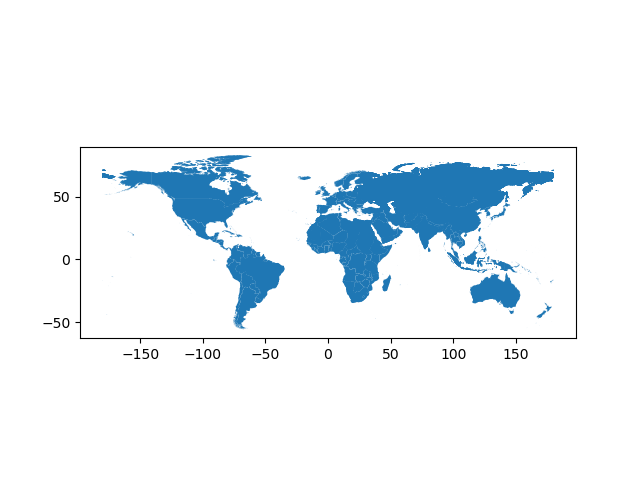

In [37]:
world.plot()

In [14]:
world.head()

,CNTRY_NAME,AREA,CAPNAME,CAPLONG,CAPLAT,FEATUREID,COWCODE,COWSYEAR,COWSMONTH,COWSDAY,COWEYEAR,COWEMONTH,COWEDAY,GWCODE,GWSYEAR,GWSMONTH,GWSDAY,GWEYEAR,GWEMONTH,GWEDAY,ISONAME,ISO1NUM,ISO1AL2,ISO1AL3,geometry
0,Guyana,211982.004988,Georgetown,-58.2,6.800000,0,110,1966,5,26,2016,6,30,110,1966,5,26,2016,6,30,Guyana,328,GY,GUY,"POLYGON ((-58.1726178865394 6.812218090163412,..."
1,Suriname,145952.274029,Paramaribo,-55.2,5.833333,1,115,1975,11,25,2016,6,30,115,1975,11,25,2016,6,30,Suriname,740,SR,SUR,"POLYGON ((-55.12796388370384 5.82217308924136,..."
2,Trinidad and Tobago,5041.728952,Port-of-Spain,-61.5,10.650000,2,52,1962,8,31,2016,6,30,52,1962,8,31,2016,6,30,Trinidad and Tobago,780,TT,TTO,(POLYGON ((-61.0794458892466 10.82416409389982...
3,Venezuela,916782.217193,Caracas,-66.9,10.500000,3,101,1946,1,1,2016,6,30,101,1946,1,1,2016,6,30,Venezuela,862,VE,VEN,(POLYGON ((-66.3102908941182 10.62601809371529...
4,Samoa,2955.212366,Apia,-172.0,-13.800000,4,990,1976,12,15,2016,6,30,990,1962,1,1,2016,6,30,Samoa,882,WS,WSM,(POLYGON ((-172.5964999931049 -13.509108928762...


This is a shapefile which has an excellent number of grouping units as well as the proper geographical borders of entities within the international system at a given time. Found here http://nils.weidmann.ws/projects/cshapes.html

In [38]:
world = world[world.COWEYEAR == 2016]

<IPython.core.display.Javascript object>


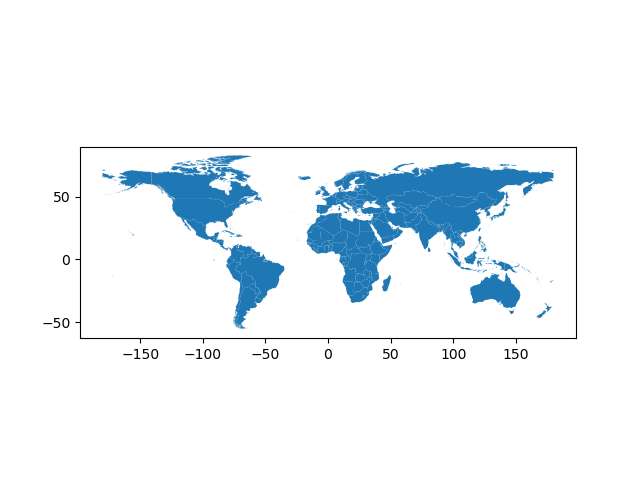

In [39]:
world.plot()

Now we have a world map! Let's check out the PTS values for each country in a single year.

In [40]:
pts_2016 = left_merge[left_merge.year == 2014]

In [41]:
world_pts = world.merge(pts_2016, left_on='COWCODE', right_on='ccode', how='left')

With this merge we make sure that we merge on the spatial file, so that way we still have the geometry column.

In [42]:
world_pts.head()

,CNTRY_NAME,AREA,CAPNAME,CAPLONG,CAPLAT,FEATUREID,COWCODE,COWSYEAR,COWSMONTH,COWSDAY,COWEYEAR,COWEMONTH,COWEDAY,GWCODE,GWSYEAR,GWSMONTH,GWSDAY,GWEYEAR,GWEMONTH,GWEDAY,ISONAME,ISO1NUM,ISO1AL2,ISO1AL3,geometry,ccode,country,leader,year,elected,age,male,militarycareer,government,prev_conflict,pt_suc,pt_attempt,precip,couprisk,democracy,autocracy,day,date,GEO,_ISO3N_,M49 Code_x,percap cals,Year,COW_Code_N,PTS_A,PTS_H,PTS_S
0,Guyana,211982.004988,Georgetown,-58.2,6.800000,0,110,1966,5,26,2016,6,30,110,1966,5,26,2016,6,30,Guyana,328,GY,GUY,"POLYGON ((-58.1726178865394 6.812218090163412,...",110,Guyana,Ramotar,2014.0,1.0,64.0,1.0,0.0,Parliamentary Democracy,0.0,0.0,0.0,-0.901823,0.000544,1.0,0.0,1.0,12/1/2014,South America,328.0,328.0,NaN,2014.0,110.0,2.0,NaN,2.0
1,Suriname,145952.274029,Paramaribo,-55.2,5.833333,1,115,1975,11,25,2016,6,30,115,1975,11,25,2016,6,30,Suriname,740,SR,SUR,"POLYGON ((-55.12796388370384 5.82217308924136,...",115,Suriname,Bouterse,2014.0,1.0,69.0,1.0,1.0,Parliamentary Democracy,0.0,0.0,0.0,-0.958657,0.000659,1.0,0.0,1.0,12/1/2014,South America,740.0,740.0,NaN,2014.0,115.0,1.0,NaN,2.0
2,Trinidad and Tobago,5041.728952,Port-of-Spain,-61.5,10.650000,2,52,1962,8,31,2016,6,30,52,1962,8,31,2016,6,30,Trinidad and Tobago,780,TT,TTO,(POLYGON ((-61.0794458892466 10.82416409389982...,52,Trinidad and Tobago,Persad-Bissessar,2014.0,1.0,62.0,0.0,0.0,Parliamentary Democracy,0.0,0.0,0.0,-0.141697,0.000468,1.0,0.0,1.0,12/1/2014,Caribbean,780.0,780.0,NaN,2014.0,52.0,2.0,NaN,2.0
3,Venezuela,916782.217193,Caracas,-66.9,10.500000,3,101,1946,1,1,2016,6,30,101,1946,1,1,2016,6,30,Venezuela,862,VE,VEN,(POLYGON ((-66.3102908941182 10.62601809371529...,101,Venezuela,Nicolas Maduro,2014.0,1.0,52.0,1.0,0.0,Personal Dictatorship,0.0,0.0,0.0,-0.562622,0.000927,0.0,1.0,1.0,12/1/2014,South America,862.0,862.0,NaN,2014.0,101.0,3.0,3.0,4.0
4,Samoa,2955.212366,Apia,-172.0,-13.800000,4,990,1976,12,15,2016,6,30,990,1962,1,1,2016,6,30,Samoa,882,WS,WSM,(POLYGON ((-172.5964999931049 -13.509108928762...,990,Samoa,Tuilaepa Sailele Malielegaoi,2014.0,1.0,69.0,1.0,0.0,Parliamentary Democracy,0.0,0.0,0.0,-0.117618,0.000370,1.0,0.0,1.0,12/1/2014,Polynesia,882.0,882.0,NaN,2014.0,990.0,NaN,NaN,1.0


<IPython.core.display.Javascript object>


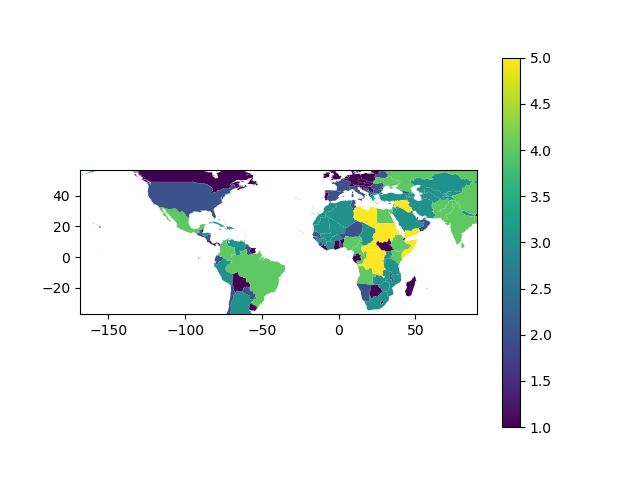

In [43]:
world_pts.plot(column='PTS_A', legend=True)

## Spatial to Spatial Joins

Now we have a data cross-sectional spatial data frame of 2014, lets do some joins to some points.

In [44]:
ged_2014 = pd.read_csv('ged_2014.csv')

In [45]:
ged_2014.head()

,id,year,active_year,type_of_violence,conflict_new_id,conflict_name,dyad_new_id,dyad_name,side_a_new_id,gwnoa,side_a,side_b_new_id,gwnob,side_b,number_of_sources,source_article,source_office,source_date,source_headline,source_original,where_prec,where_coordinates,adm_1,adm_2,latitude,longitude,priogrid_gid,country,country_id,region,event_clarity,date_prec,date_start,date_end,deaths_a,deaths_b,deaths_civilians,deaths_unknown,low,best,high
0,183917,2014,0,2,4988,Greenlanders - NDV,5598,Greenlanders - NDV,1173,NaN,Greenlanders,657,NaN,NDV,1,"""Feelrivers,2014-04-26,BLOOD BATH IN ABUA, AS ...",Feelrivers,4/26/14,"BLOOD BATH IN ABUA, AS CULT GROUPS BATTLE FOR ...",NaN,1,Otari village,Rivers state,Abua/Odual lga,4.85989,6.661750,136454,Nigeria,475,Africa,2,4,4/1/14,4/25/14,0,0,0,2,2,2,2
1,157360,2014,1,1,13349,Myanmar (Burma):Palaung,14273,Government of Myanmar (Burma) - PSLF,144,775.0,Government of Myanmar (Burma),5965,NaN,PSLF,1,"""The Irrawaddy,2014-07-18,178 Govt Troops Kill...",The Irrawaddy,7/18/14,178 Govt Troops Killed by TNLA This Year: Rebe...,TNLA headquarters,5,Northern Shan State,Shan State,NaN,22.95000,97.950000,162556,Myanmar (Burma),775,Asia,2,5,1/1/14,7/18/14,0,10,0,0,10,10,166
2,164198,2014,1,1,329,Ethiopia:Ogaden,719,Government of Ethiopia - ONLF,97,530.0,Government of Ethiopia,497,NaN,ONLF,-1,NaN,NaN,NaN,NaN,AGGREGATION,4,Somali state,Somali state,NaN,7.00000,44.000000,140129,Ethiopia,530,Africa,2,5,1/1/14,12/31/14,0,0,0,25,25,25,0
3,128827,2014,1,2,4948,Birom - Fulani,5558,Birom - Fulani,589,NaN,Birom,607,NaN,Fulani,1,"""All Africa,2014-01-07,Nigerian Military Confi...",All Africa,1/7/14,"Nigerian Military Confirms Six Killed, Five In...","the spokesperson of the Special Task Force, ST...",1,Bachit village,Plateau state,Riyom lga,9.51667,8.700000,143658,Nigeria,475,Africa,3,2,1/6/14,1/7/14,0,0,0,0,0,0,6
4,114000,2014,1,1,259,Iraq:Government,524,Government of Iraq - IS,116,645.0,Government of Iraq,234,NaN,IS,1,"""Agence France Presse,2014-01-10,Clashes erupt...",Agence France Presse,1/10/14,Clashes erupt in west Iraq as standoff persists,NaN,1,Al Khālidīyah town,Al Anbār province,Qaḑā’ ar Ramādī,33.38728,43.522943,177568,Iraq,645,Middle East,1,1,1/10/14,1/10/14,0,0,2,0,2,2,2


We are working with the UCDP GED data set here. This records each event of violence be it state, nonstate, or onesided. First thing we need to do is make it a spatial object.

In [46]:
ged_geometry = [Point(xy) for xy in zip(ged_2014.longitude, ged_2014.latitude)]

In [47]:
ged_gdf = gpd.GeoDataFrame(ged_2014, geometry = ged_geometry)

<IPython.core.display.Javascript object>


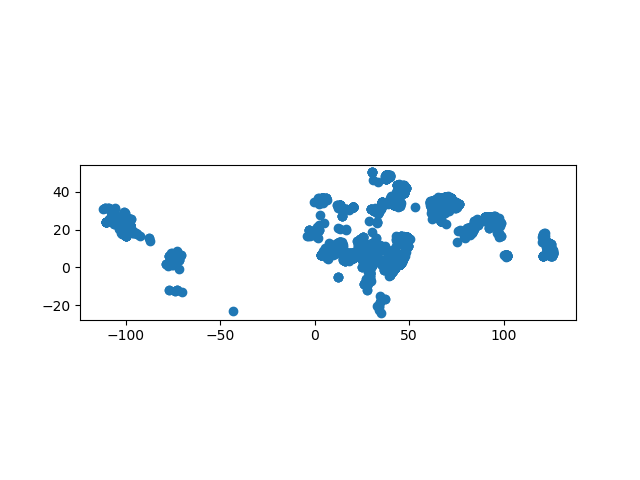

In [48]:
ged_gdf.plot()

Now lets pick a few countries that we are interested in and make a new geospatial shapefile. 

In [49]:
world_pts.CNTRY_NAME

0                              Guyana
1                            Suriname
2                 Trinidad and Tobago
3                           Venezuela
4                               Samoa
5                               Tonga
6                           Argentina
7                             Bolivia
8                              Brazil
9                               Chile
10                            Ecuador
11                           Paraguay
12                               Peru
13                            Uruguay
14                          Guatemala
15                             Mexico
16                           Barbados
17                           Dominica
18                            Grenada
19                          St. Lucia
20     St. Vincent and the Grenadines
21                 Dominican Republic
22                              Haiti
23                            Jamaica
24                            Bahamas
25                             Belize
26          

In [50]:
countrys = ['Uganda', 'Central African Republic', 'Congo, DRC']

In [51]:
central_af = world_pts[world_pts.CNTRY_NAME.isin(countrys)]

In [52]:
from fiona.crs import from_epsg
import matplotlib.pyplot as plt
central_af.crs = from_epsg(4326)
ged_gdf.crs = from_epsg(4326)

<IPython.core.display.Javascript object>


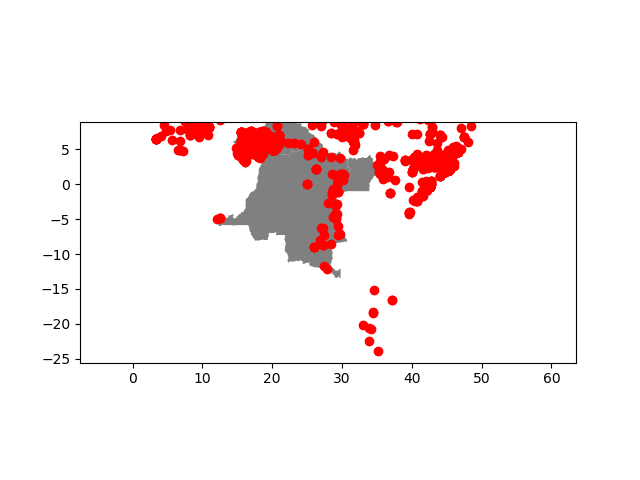

In [53]:
fig, ax = plt.subplots()
central_af.plot(ax=ax, facecolor='gray');
ged_gdf.plot(ax=ax, color='red');
ax.set_aspect('equal')

In [54]:
central_af.head()

,CNTRY_NAME,AREA,CAPNAME,CAPLONG,CAPLAT,FEATUREID,COWCODE,COWSYEAR,COWSMONTH,COWSDAY,COWEYEAR,COWEMONTH,COWEDAY,GWCODE,GWSYEAR,GWSMONTH,GWSDAY,GWEYEAR,GWEMONTH,GWEDAY,ISONAME,ISO1NUM,ISO1AL2,ISO1AL3,geometry,ccode,country,leader,year,elected,age,male,militarycareer,government,prev_conflict,pt_suc,pt_attempt,precip,couprisk,democracy,autocracy,day,date,GEO,_ISO3N_,M49 Code_x,percap cals,Year,COW_Code_N,PTS_A,PTS_H,PTS_S
64,Central African Republic,6.226966e+05,Bangui,18.58333,4.366667,70,482,1960,8,13,2016,6,30,482,1960,8,13,2016,6,30,Central African Republic,140,CF,CAF,"POLYGON ((20.4533001866867 4.523791088032141, ...",482,Cen African Rep,Samba-Panza,2014.0,0.0,58.0,0.0,0.0,Provisional - Civilian,1.0,0.0,0.0,-0.153622,0.002999,0.0,1.0,1.0,12/1/2014,Middle Africa,140.0,140.0,NaN,2014.0,482.0,5.0,5.0,5.0
156,"Congo, DRC",2.342043e+06,Kinshasa,15.31500,-4.329722,170,490,1960,6,30,2016,6,30,490,1960,6,30,2016,6,30,"Congo, Democratic Republic of the",180,CD,COD,POLYGON ((16.10007318263243 -5.859372921637927...,490,Congo/Zaire,Joseph Kabila,2014.0,1.0,43.0,1.0,0.0,Personal Dictatorship,0.0,0.0,0.0,-0.067237,0.001102,0.0,1.0,1.0,12/1/2014,Middle Africa,180.0,NaN,NaN,2014.0,490.0,5.0,3.0,5.0
188,Uganda,2.437028e+05,Kampala,32.56556,0.315556,59,500,1962,10,9,2016,6,30,500,1962,10,9,2016,6,30,Uganda,800,UG,UGA,POLYGON ((32.89035419826959 -0.999708917112016...,500,Uganda,Museveni,2014.0,1.0,70.0,1.0,0.0,Personal Dictatorship,0.0,0.0,0.0,-0.080365,0.001301,0.0,1.0,1.0,12/1/2014,Eastern Africa,800.0,800.0,NaN,2014.0,500.0,3.0,3.0,3.0


In [55]:
car_pts = ged_gdf.within(central_af.loc[64, 'geometry'])
car_data = ged_gdf.loc[car_pts]

In [56]:
drc_pts = ged_gdf.within(central_af.loc[156, 'geometry'])
drc_data = ged_gdf.loc[drc_pts]

In [57]:
uga_pts = ged_gdf.within(central_af.loc[188, 'geometry'])
uga_data = ged_gdf.loc[uga_pts]

<IPython.core.display.Javascript object>


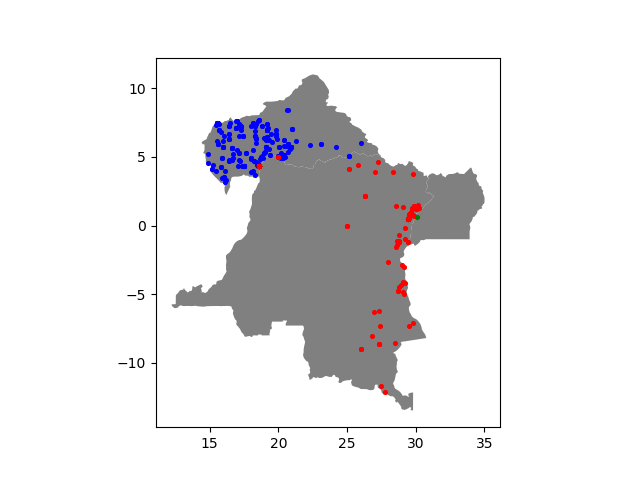

In [58]:
fig, ax = plt.subplots()
central_af.plot(ax=ax, facecolor='gray');
car_data.plot(ax=ax, color='blue', markersize=uga_data['best']);
drc_data.plot(ax=ax, color='red', markersize=uga_data['best']);
uga_data.plot(ax=ax, color='green', markersize=uga_data['best']);
ax.set_aspect('equal')

In [59]:
deaths = [sum(car_data.best),sum(drc_data.best),sum(uga_data.best)]

In [60]:
deaths

[2608, 1975, 7]

In [61]:
central_af['deaths'] = deaths

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [62]:
central_af

,CNTRY_NAME,AREA,CAPNAME,CAPLONG,CAPLAT,FEATUREID,COWCODE,COWSYEAR,COWSMONTH,COWSDAY,COWEYEAR,COWEMONTH,COWEDAY,GWCODE,GWSYEAR,GWSMONTH,GWSDAY,GWEYEAR,GWEMONTH,GWEDAY,ISONAME,ISO1NUM,ISO1AL2,ISO1AL3,geometry,ccode,country,leader,year,elected,age,male,militarycareer,government,prev_conflict,pt_suc,pt_attempt,precip,couprisk,democracy,autocracy,day,date,GEO,_ISO3N_,M49 Code_x,percap cals,Year,COW_Code_N,PTS_A,PTS_H,PTS_S,deaths
64,Central African Republic,6.226966e+05,Bangui,18.58333,4.366667,70,482,1960,8,13,2016,6,30,482,1960,8,13,2016,6,30,Central African Republic,140,CF,CAF,"POLYGON ((20.4533001866867 4.523791088032141, ...",482,Cen African Rep,Samba-Panza,2014.0,0.0,58.0,0.0,0.0,Provisional - Civilian,1.0,0.0,0.0,-0.153622,0.002999,0.0,1.0,1.0,12/1/2014,Middle Africa,140.0,140.0,NaN,2014.0,482.0,5.0,5.0,5.0,2608
156,"Congo, DRC",2.342043e+06,Kinshasa,15.31500,-4.329722,170,490,1960,6,30,2016,6,30,490,1960,6,30,2016,6,30,"Congo, Democratic Republic of the",180,CD,COD,POLYGON ((16.10007318263243 -5.859372921637927...,490,Congo/Zaire,Joseph Kabila,2014.0,1.0,43.0,1.0,0.0,Personal Dictatorship,0.0,0.0,0.0,-0.067237,0.001102,0.0,1.0,1.0,12/1/2014,Middle Africa,180.0,NaN,NaN,2014.0,490.0,5.0,3.0,5.0,1975
188,Uganda,2.437028e+05,Kampala,32.56556,0.315556,59,500,1962,10,9,2016,6,30,500,1962,10,9,2016,6,30,Uganda,800,UG,UGA,POLYGON ((32.89035419826959 -0.999708917112016...,500,Uganda,Museveni,2014.0,1.0,70.0,1.0,0.0,Personal Dictatorship,0.0,0.0,0.0,-0.080365,0.001301,0.0,1.0,1.0,12/1/2014,Eastern Africa,800.0,800.0,NaN,2014.0,500.0,3.0,3.0,3.0,7


<IPython.core.display.Javascript object>


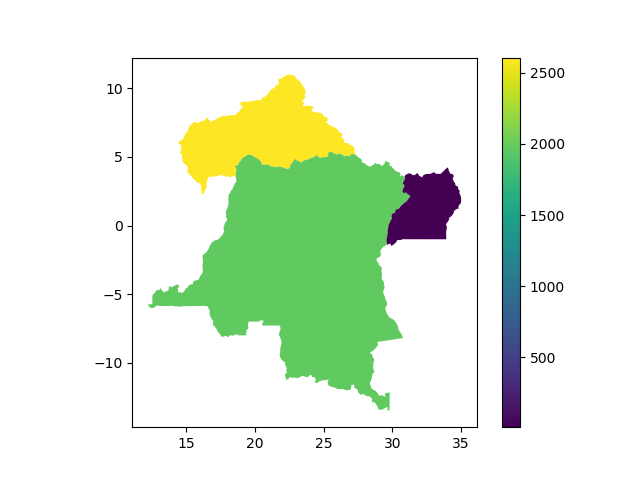

In [63]:
central_af.plot(column='deaths', legend=True)

## BONUS Download Country Code Maker!

https://github.com/JELambert/ccode_replace_python

In [65]:
from ccode_replace_python import replace_ccode_country as rcc
#ccode_df = rcc.ccode_make(unmade_df, 'Country Name')